# Primeiro dataset

Dataset escolhido: [https://archive.ics.uci.edu/dataset/602/dry+bean+dataset](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset)

## Extraindo os dados

In [3]:
import pandas as pd

path_to_data = 'data/Dry_Bean_Dataset.xlsx'

# Carregar base de dados
# DataFrame
HEADER_ROW = 0
dataset = pd.read_excel(path_to_data, sheet_name="Dry_Beans_Dataset",header=HEADER_ROW)

# DEBUG - Verificar se a base de dados foi carregada corretamente
# dataset.head(20)
# dataset.shape

## Transformando os dados

In [4]:
# Transformando as labels em valores numéricos
dataset['Class'] = dataset['Class'].astype('category').cat.codes

## Separando os dados
Separação dos dados em features (X) e target (y)

In [5]:
NUM_OF_COLUMNS = len(dataset.columns)

y = dataset.iloc[:,-1] # extrai o target (última coluna)
X = dataset.iloc[:,0:NUM_OF_COLUMNS-1] # extrai as features (todas as colunas menos a última)

## Normalizando os dados
Deixando os valores de todas as colunas entre 0 e 1

In [6]:
from sklearn.preprocessing import MinMaxScaler

x_values = X.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_values)
X = pd.DataFrame(x_scaled)

## Criando os folds
Serão 10 folds para o k-fold cross validation

In [7]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Transforma para array NumPy
X = np.array(X)
y = np.array(y)

# Define o número de folds
N_FOLDS = 10
kf = StratifiedKFold(n_splits=N_FOLDS)

# features e target de treino
X_train = []
y_train = []

# features e target de teste
X_test = []
y_test = []

for train_index, test_index in kf.split(X, y):
  X_train.append(X[train_index])
  X_test.append(X[test_index])

  y_train.append(y[train_index])
  y_test.append(y[test_index])

## Obtendo os scores dos modelos

In [8]:
from typing import List, Any
from sklearn import metrics

def predict_and_get_accuracy(model, X_test: List[Any], y_test: List[Any]) -> float:
  y_pred = model.predict(X_test)
  accuracy = metrics.accuracy_score(y_test, y_pred)

  return accuracy

### Árvore de decisão

In [9]:
from sklearn.tree import DecisionTreeClassifier

gini_tree_results = []
entropy_tree_results = []

TREE_RANDOM_STATE = 42
TREE_MAX_DEPTH = 5

# Treinamento e avaliação do modelo com critério entropy
for i in range(N_FOLDS):
  entropy_tree_model = DecisionTreeClassifier(criterion="entropy", random_state=TREE_RANDOM_STATE,
    max_depth=TREE_MAX_DEPTH)
  entropy_tree_model = entropy_tree_model.fit(X_train[i], y_train[i])

  entropy_tree_results.append(predict_and_get_accuracy(entropy_tree_model, X_test[i], y_test[i]))

print(f"Acurácia média da árvore de decisão com ENTROPY: { \
  np.mean(entropy_tree_results)*100:.2f}%")

# Treinamento e avaliação do modelo com critério gini
for i in range(N_FOLDS):
  gini_tree_model = DecisionTreeClassifier(criterion="gini", random_state=TREE_RANDOM_STATE,
    max_depth=TREE_MAX_DEPTH)
  gini_tree_model = gini_tree_model.fit(X_train[i], y_train[i])

  gini_tree_results.append(predict_and_get_accuracy(gini_tree_model, X_test[i], y_test[i]))

print(f"Acurácia média da árvore de decisão com GINI: { \
  np.mean(gini_tree_results)*100:.2f}%")

Acurácia média da árvore de decisão com ENTROPY: 79.58%
Acurácia média da árvore de decisão com GINI: 74.13%


### K-Nearest Neighbors (KNN)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

five_neighbors_results = []
ten_neighbors_results = []

# Treinamento e avaliação do modelo com 5 vizinhos
for i in range(N_FOLDS):
  five_neighbors_model = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
  five_neighbors_model = five_neighbors_model.fit(X_train[i], y_train[i])

  five_neighbors_results.append(predict_and_get_accuracy(five_neighbors_model, X_test[i], y_test[i]))

print(f"Acurácia média do KNN com 5 vizinhos: { \
  np.mean(five_neighbors_results)*100:.2f}%")

# Treinamento e avaliação do modelo com 10 vizinhos
for i in range(N_FOLDS):
  ten_neighbors_model = KNeighborsClassifier(n_neighbors=10, metric="euclidean")
  ten_neighbors_model = ten_neighbors_model.fit(X_train[i], y_train[i])

  ten_neighbors_results.append(predict_and_get_accuracy(ten_neighbors_model, X_test[i], y_test[i]))

print(f"Acurácia média do KNN com 10 vizinhos: { \
  np.mean(ten_neighbors_results)*100:.2f}%")

Acurácia média do KNN com 5 vizinhos: 87.61%
Acurácia média do KNN com 10 vizinhos: 88.36%


### Multilayer Perceptron (MLP)

#### Treinando os modelos

In [11]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

FIRST_ARCHITECTURE = (10, 2,)
SECOND_ARCHITECTURE = (50, )

mlp_first_architecture_results = {
  "tanh": [],
  "relu": [],
}

mlp_second_architecture_results = {
  "tanh": [],
  "relu": [],
}

# Primeira posição da tupla é o nome do modelo e a segunda é a lista de loss
loss_curves = {
  "first_relu": (f"MLP (ReLU) com arquitetura {FIRST_ARCHITECTURE}", []),
  "second_relu": (f"MLP (ReLU) com arquitetura {SECOND_ARCHITECTURE}", []),
  "first_tanh": (f"MLP (Tanh) com arquitetura {FIRST_ARCHITECTURE}", []),
  "second_tanh": (f"MLP (Tanh) com arquitetura {SECOND_ARCHITECTURE}", []),
}

for i in range(N_FOLDS):
  # Treinamento e avaliação do modelo com função de ativação ReLU (FIRST_ACHITECTURE)
  first_relu_mlp_model = MLPClassifier(hidden_layer_sizes=FIRST_ARCHITECTURE,
    random_state=42, max_iter=1000)
  first_relu_mlp_model = first_relu_mlp_model.fit(X_train[i], y_train[i])

  mlp_first_architecture_results["relu"].append(
    predict_and_get_accuracy(first_relu_mlp_model, X_test[i], y_test[i]))
  loss_curves["first_relu"][1].append(first_relu_mlp_model.loss_curve_)

  # Treinamento e avaliação do modelo com função de ativação ReLU (SECOND_ARCHITECTURE)  
  second_relu_mlp_model = MLPClassifier(hidden_layer_sizes=SECOND_ARCHITECTURE,
    random_state=42, max_iter=1000)
  second_relu_mlp_model = second_relu_mlp_model.fit(X_train[i], y_train[i])

  mlp_second_architecture_results["relu"].append(
    predict_and_get_accuracy(second_relu_mlp_model, X_test[i], y_test[i]))
  loss_curves["second_relu"][1].append(second_relu_mlp_model.loss_curve_)
  
  # Treinamento e avaliação do modelo com função de ativação TANH (FIRST_ARCHITECTURE)
  first_tanh_mlp_model = MLPClassifier(hidden_layer_sizes=FIRST_ARCHITECTURE,
    random_state=42, max_iter=1000, activation="tanh")
  first_tanh_mlp_model = first_tanh_mlp_model.fit(X_train[i], y_train[i])

  mlp_first_architecture_results["tanh"].append(
    predict_and_get_accuracy(first_tanh_mlp_model, X_test[i], y_test[i]))
  loss_curves["first_tanh"][1].append(first_tanh_mlp_model.loss_curve_)
  
  # Treinamento e avaliação do modelo com função de ativação TANH (SECOND_ARCHITECTURE)
  second_tanh_mlp_model = MLPClassifier(hidden_layer_sizes=SECOND_ARCHITECTURE,
    random_state=42, max_iter=1000, activation="tanh")
  second_tanh_mlp_model = second_tanh_mlp_model.fit(X_train[i], y_train[i])

  mlp_second_architecture_results["tanh"].append(
    predict_and_get_accuracy(second_tanh_mlp_model, X_test[i], y_test[i]))
  loss_curves["second_tanh"][1].append(second_tanh_mlp_model.loss_curve_)

# Exibindo as acurácias dos modelos
print(f"Acurácia média da MLP com arquitetura {FIRST_ARCHITECTURE} e função de ativação ReLU: { \
  np.mean(mlp_first_architecture_results["relu"])*100:.2f}%")

print(f"Acurácia média da MLP com arquitetura {SECOND_ARCHITECTURE} e função de ativação ReLU: { \
  np.mean(mlp_second_architecture_results["relu"])*100:.2f}%")

print(f"Acurácia média da MLP com arquitetura {FIRST_ARCHITECTURE} e função de ativação TANH: { \
  np.mean(mlp_first_architecture_results["tanh"])*100:.2f}%")

print(f"Acurácia média da MLP com arquitetura {SECOND_ARCHITECTURE} e função de ativação TANH: { \
  np.mean(mlp_second_architecture_results["tanh"])*100:.2f}%")

Acurácia média da MLP com arquitetura (10, 2) e função de ativação ReLU: 87.71%
Acurácia média da MLP com arquitetura (50,) e função de ativação ReLU: 88.59%
Acurácia média da MLP com arquitetura (10, 2) e função de ativação TANH: 88.60%
Acurácia média da MLP com arquitetura (50,) e função de ativação TANH: 88.92%


### K-Means

#### Funções utilizadas para o mapeamento das labels geradas para os clusters

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

def create_cluster_label_mapping_lists(n_clusters: int) -> List[List[int]]:
  """
  Cria a lista com as listas aninhadas que mapeiam os targets (classes) para cada cluster.

  Parametros
  ----------
  n_clusters : int -
    Número de clusters distintos.
  
  Retorna
  ----------
  List[List[int]]
    Uma lista onde cada posição corresponde a um cluster (índice 0 == cluster 0) e, nessa posição,
    há uma lista que armazenará os targets (valores classificados) para o cluster em questão.
  """
  return [[] for i in range(n_clusters)]

def map_clusters_to_labels(model: KMeans, n_clusters: int, y_train: np.ndarray):
  """
  Obtém as labels dos clusters do KMeans e mapeia os targets (classes) correspondentes a cada
  cluster.

  Parametros
  ----------
  model : KMeans -
    Modelo KMeans que é utilizado para obter as labels dos clusters.
  n_clusters : int -
    Número de clusters distintos.
  y_train : np.ndarray
    Array NumPy com os targets do conjunto de treino.
  
  Retorna
  ----------
  List[List[int]]
    Uma lista onde cada posição corresponde a um cluster (índice 0 == cluster 0) e, nessa posição,
    há uma lista contendo os targets (valores classificados) para o cluster em questão.
  """
  labels = model.labels_

  y_train_as_list = y_train.tolist()

  mapped_cluster_labels = create_cluster_label_mapping_lists(n_clusters)

  for i in range(len(y_train)):  # para cada y do conjunto de treino
    for c in range(n_clusters):  # para cada cluster
      if labels[i] == c:

      # se a label atual for igual ao número do cluster atual,
      # adicione o valor de y (target) correspondente ao array de posição c
      # (colocar o y de treino no seu cluster equivalente)
      # labels[i] foi classificado como y_train_as_list[i]

        mapped_cluster_labels[c].append(y_train_as_list[i])
  
  return mapped_cluster_labels

def create_label_to_class_mapping(mapped_cluster_labels: List[List[int]], n_clusters: int
  ) -> dict[int, int]:
  """
  Obtém a classe associada (target) a cada cluster.
  
  Parametros
  ----------
  mapped_cluster_labels : List[List[int]] -
    Uma lista onde cada cluster é representado por uma lista aninhada contendo os targets (y)
    correspondentes a tal cluster.
  n_clusters : int -
    O número de clusters.

  Retorna
  ----------
  dict[int, int]
    Um dicionário com o cluster como chave e o target correspondente a ele como valor
  """
  mapping = {}
  
  for c in range(n_clusters):
    counter = Counter(mapped_cluster_labels[c])  # contar a classe que mais aparece no cluster c
    target = counter.most_common(1)[0][0]  # retorna a classe com maior frequência
    mapping[c] = target  # mapear o valor do cluster c para o valor da classe correspondente
  
  return mapping

#### Treino do modelo e aplicação do mapeamento
Além do modelo ser treinado, os clusters precisam ser mapeados para as suas classes correspondentes
(targets correspondentes).

In [13]:

# O número de clusters é igual ao número de classes
KMEANS_NUM_OF_CLUSTERS = len(set(y))

kmeans_results = []

for i in range(N_FOLDS):
  kmeans_model = KMeans(n_clusters=KMEANS_NUM_OF_CLUSTERS, random_state=42)
  kmeans_model = kmeans_model.fit(X_train[i])

  mapped_cluster_labels = map_clusters_to_labels(kmeans_model, KMEANS_NUM_OF_CLUSTERS, y_train[i])
  mapping = create_label_to_class_mapping(mapped_cluster_labels, KMEANS_NUM_OF_CLUSTERS)

  # neste caso, não podemos usar o predict_and_get_accuracy pois precisamos mapear os resultados
  # de cluster para target antes de obter a acurácia
  current_result = kmeans_model.predict(X_test[i])
  current_result = [mapping[i] for i in current_result]

  kmeans_results.append(metrics.accuracy_score(y_test[i], current_result))

print(f"Acurácia média do K-Means com {KMEANS_NUM_OF_CLUSTERS} clusters: { \
  np.mean(kmeans_results)*100:.2f}%")

Acurácia média do K-Means com 7 clusters: 80.13%


## Resumo dos resultados
Acurácia de cada modelo e os resultados do MLP com as curvas de loss para cada modelo (10 curvas - 1 por fold)

### Acurácia de cada modelo

In [14]:
# Exibindo as acurácias dos modelos
print(f"Acurácia média da árvore de decisão com ENTROPY: { \
  np.mean(entropy_tree_results)*100:.2f}%")

print(f"Acurácia média da árvore de decisão com GINI: { \
  np.mean(gini_tree_results)*100:.2f}%")

print(f"Acurácia média do KNN com 5 vizinhos: { \
  np.mean(five_neighbors_results)*100:.2f}%")

print(f"Acurácia média do KNN com 10 vizinhos: { \
  np.mean(ten_neighbors_results)*100:.2f}%")

print(f"Acurácia média do K-Means com {KMEANS_NUM_OF_CLUSTERS} clusters: { \
  np.mean(kmeans_results)*100:.2f}%")

print(f"Acurácia média da MLP com arquitetura {FIRST_ARCHITECTURE} e função de ativação ReLU: { \
  np.mean(mlp_first_architecture_results["relu"])*100:.2f}%")

print(f"Acurácia média da MLP com arquitetura {SECOND_ARCHITECTURE} e função de ativação ReLU: { \
  np.mean(mlp_second_architecture_results["relu"])*100:.2f}%")

print(f"Acurácia média da MLP com arquitetura {FIRST_ARCHITECTURE} e função de ativação TANH: { \
  np.mean(mlp_first_architecture_results["tanh"])*100:.2f}%")

print(f"Acurácia média da MLP com arquitetura {SECOND_ARCHITECTURE} e função de ativação TANH: { \
  np.mean(mlp_second_architecture_results["tanh"])*100:.2f}%")

Acurácia média da árvore de decisão com ENTROPY: 79.58%
Acurácia média da árvore de decisão com GINI: 74.13%
Acurácia média do KNN com 5 vizinhos: 87.61%
Acurácia média do KNN com 10 vizinhos: 88.36%
Acurácia média do K-Means com 7 clusters: 80.13%
Acurácia média da MLP com arquitetura (10, 2) e função de ativação ReLU: 87.71%
Acurácia média da MLP com arquitetura (50,) e função de ativação ReLU: 88.59%
Acurácia média da MLP com arquitetura (10, 2) e função de ativação TANH: 88.60%
Acurácia média da MLP com arquitetura (50,) e função de ativação TANH: 88.92%


### Curvas de loss para cada modelo do MLP
São exibidas 10 curvas por modelo, isto é, uma para cada fold.

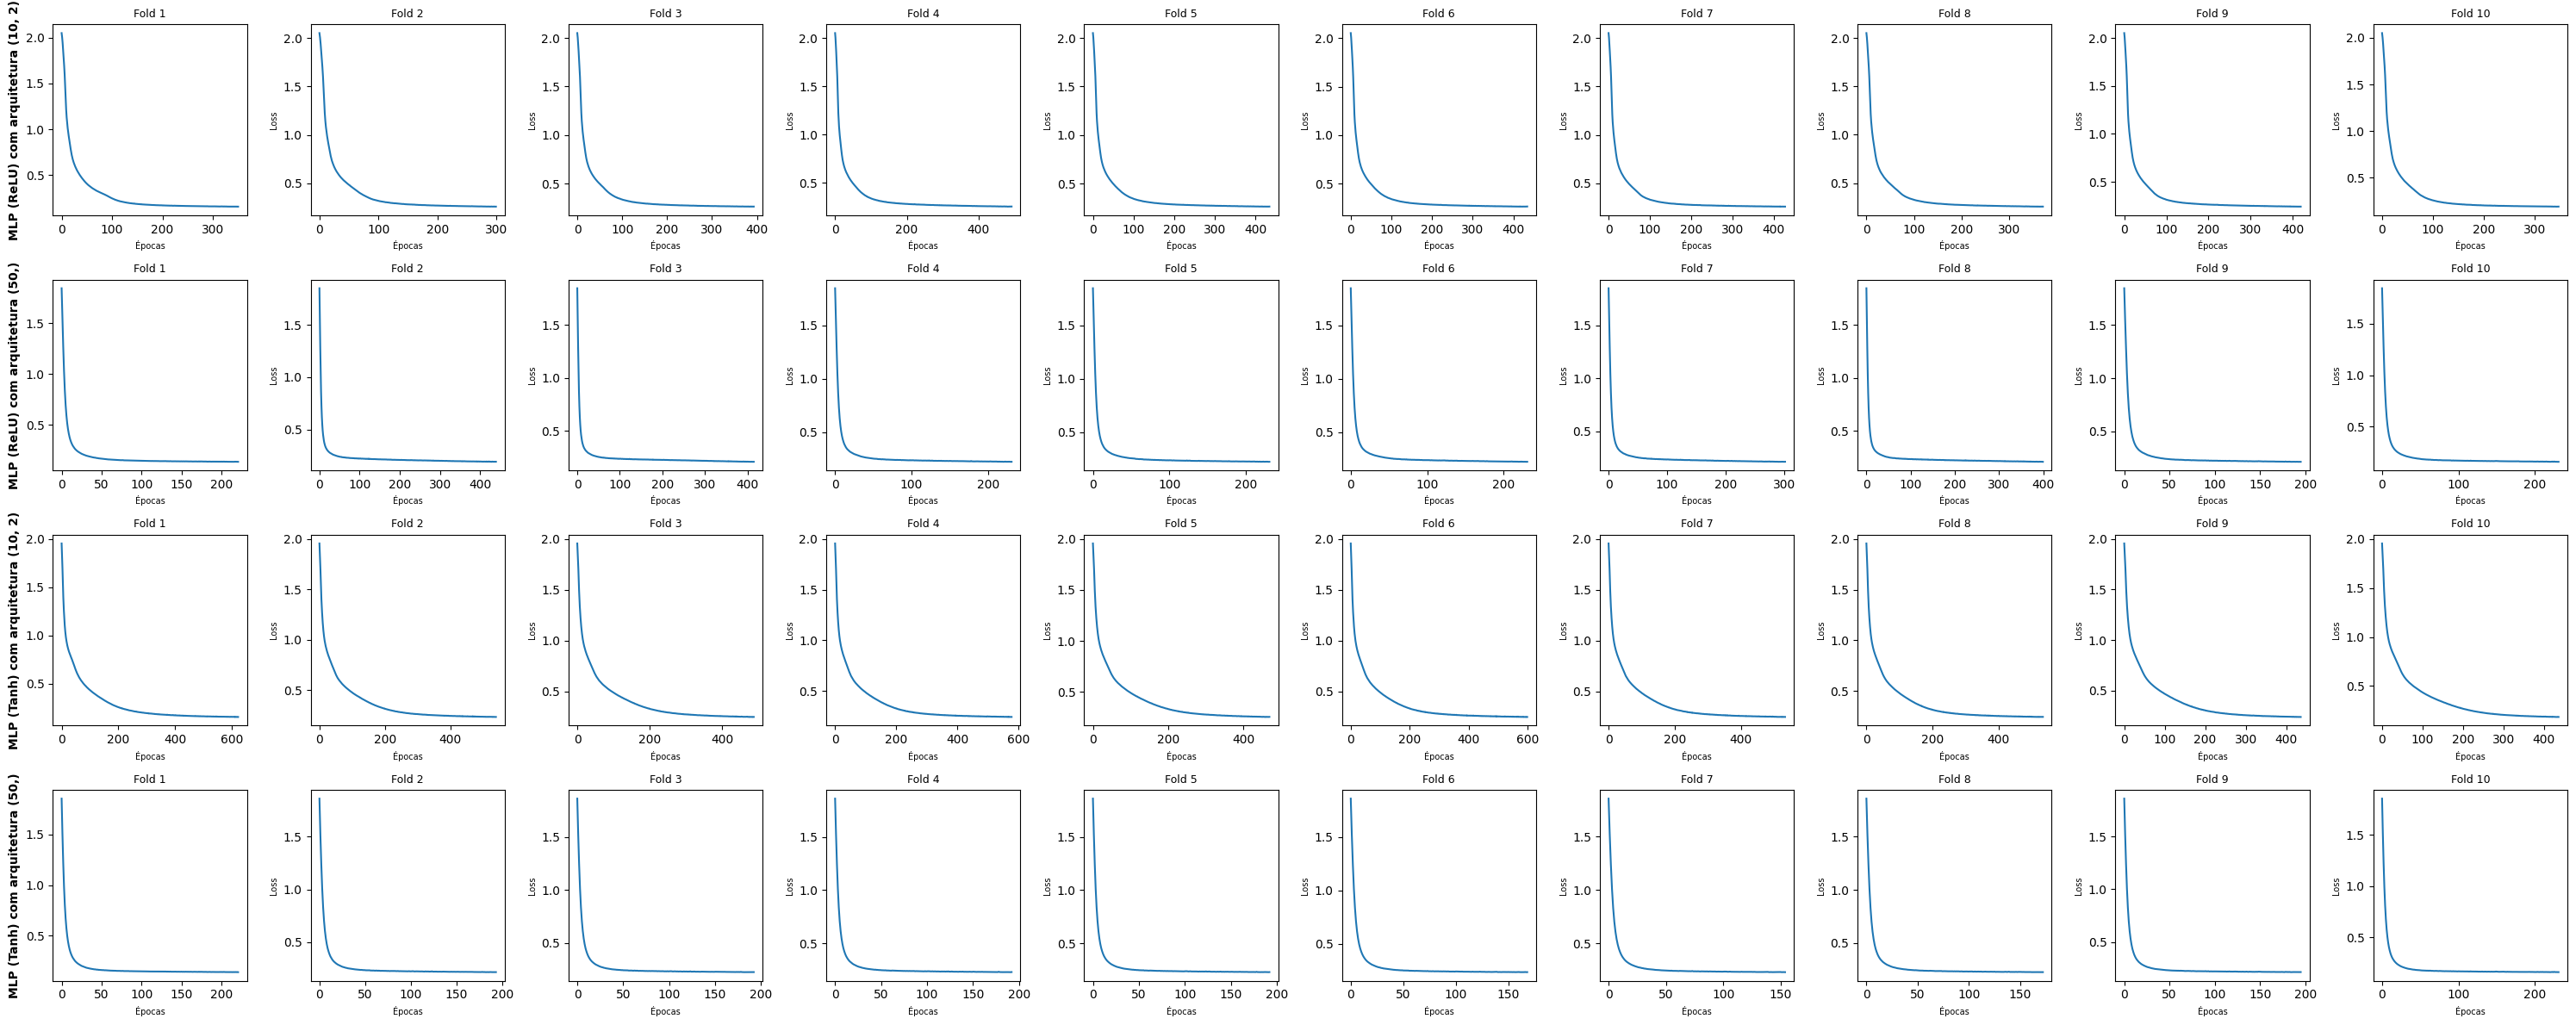

In [15]:
# Criação de uma figura com 4 linhas e 10 colunas de subplots
fig, axes = plt.subplots(4, N_FOLDS, figsize=(30, 12), sharex=False, sharey=False)

for row, current_model in enumerate(loss_curves.keys()):  # para cada modelo (linha)
  for col in range(N_FOLDS):                              # para cada fold (coluna)
    axes[row, col].plot(loss_curves[current_model][1][col])
    axes[row, col].set_title(f"Fold {col+1}", fontsize=9)
    axes[row, col].set_xlabel("Épocas", fontsize=7)
    axes[row, col].set_ylabel("Loss", fontsize=7)
  # Define o rótulo da linha com o nome do modelo (apenas no primeiro subplot da linha)
  axes[row, 0].set_ylabel(loss_curves[current_model][0], fontsize=10, weight="bold")

plt.tight_layout()  # Ajusta os espaçamentos entre os subplots
plt.show()